# How Learning Rate Affects Training Variability

We know that learning rate affects final model accuracy. But does it also affect *variability* — how much the results differ across training runs?

In this notebook, we'll train the same CNN architecture at four different learning rates, running each configuration 10 times. We'll see not just which learning rate performs best on average, but which one produces the most *consistent* results.

## Setup

In [1]:
# !pip install ictonyx tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.optimizers import Adam

import ictonyx as ix
from ictonyx import (
    ModelConfig,
    KerasModelWrapper,
    ArraysDataHandler,
    run_variability_study,
    plot_variability_summary
)

print(f"TensorFlow: {tf.__version__}")
print(f"Ictonyx: {ix.__version__}")

2026-02-11 23:58:38.148388: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 23:58:38.175280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-11 23:58:38.175306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-11 23:58:38.176146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-11 23:58:38.180614: I tensorflow/core/platform/cpu_feature_guar

TensorFlow: 2.15.0
Ictonyx: 0.0.5


## Load MNIST

In [3]:
(X_train, y_train), _ = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_train = X_train[..., np.newaxis]

# Use subset for speed

X = X_train[:5000]
y = y_train[:5000]

print(f"Training data: {X.shape}")

11490434/11490434 [==============================] - 0s 0us/step
Training data: (5000, 28, 28, 1)


## Define the Model

We need a model builder that reads the learning rate from the config. This lets us test different learning rates without rewriting the model definition.

In [4]:
def create_cnn(config: ModelConfig) -> KerasModelWrapper:
    """CNN with configurable learning rate."""
    
    learning_rate = config.get('learning_rate', 0.001)
    
    model = Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return KerasModelWrapper(model)

## Run Variability Studies at Different Learning Rates

We'll test four learning rates spanning two orders of magnitude: 0.01, 0.001, 0.0001, and 0.00001. For each one, we train 10 times and collect the results.

In [5]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
all_results = {}

data_handler = ArraysDataHandler(X, y)

for lr in learning_rates:
    print(f"\n{'='*50}")
    print(f"Learning Rate: {lr}")
    print('='*50)
    
    config = ModelConfig({
        'epochs': 5,
        'batch_size': 64,
        'learning_rate': lr,
        'verbose': 0
    })
    
    results = run_variability_study(
        model_builder=create_cnn,
        data_handler=data_handler,
        model_config=config,
        num_runs=10,
        epochs_per_run=5
    )
    
    all_results[lr] = results
    print(results.summarize())


Learning Rate: 0.01
Enabled GPU memory growth
Loading and preparing data...
Array splits - Train: 3500, Val: 500, Test: 1000
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 5
  Execution mode: in standard mode

 - Run 1: Training...


2026-02-11 23:59:02.623896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-11 23:59:02.669987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-11 23:59:02.672506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

32/32 [==============================] - 1s 14ms/step - loss: 0.1264 - accuracy: 0.9620
 - Run 1: Completed successfully
 - Run 2: Training...
32/32 [==============================] - 0s 5ms/step - loss: 0.0852 - accuracy: 0.9700
 - Run 2: Completed successfully
 - Run 3: Training...
32/32 [==============================] - 0s 4ms/step - loss: 0.1201 - accuracy: 0.9600
 - Run 3: Completed successfully
 - Run 4: Training...
32/32 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9750
 - Run 4: Completed successfully
 - Run 5: Training...
32/32 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.9700
 - Run 5: Completed successfully
 - Run 6: Training...
32/32 [==============================] - 0s 6ms/step - loss: 0.1711 - accuracy: 0.9590
 - Run 6: Completed successfully
 - Run 7: Training...
32/32 [==============================] - 0s 5ms/step - loss: 0.1508 - accuracy: 0.9600
 - Run 7: Completed successfully
 - Run 8: Training...
32/32

## Compare Results

Now let's look at the mean accuracy *and* the standard deviation for each learning rate.

In [6]:
import pandas as pd

comparison_data = []

for lr, results in all_results.items():
    accs = list(results.final_val_accuracies)
    comparison_data.append({
        'Learning Rate': lr,
        'Mean Accuracy': np.mean(accs),
        'Std Dev': np.std(accs),
        'Min': np.min(accs),
        'Max': np.max(accs),
        'Range': np.max(accs) - np.min(accs)
    })

df = pd.DataFrame(comparison_data)
df

,Learning Rate,Mean Accuracy,Std Dev,Min,Max,Range
0,0.01000,0.9548,0.008998,0.942,0.970,0.028
1,0.00100,0.9510,0.003606,0.946,0.958,0.012
2,0.00010,0.8868,0.007600,0.876,0.902,0.026
3,0.00001,0.4402,0.077094,0.302,0.534,0.232


## Visualizing Variability by Learning Rate

Let's plot the training curves and accuracy distributions for each learning rate.


Learning Rate: 0.01


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


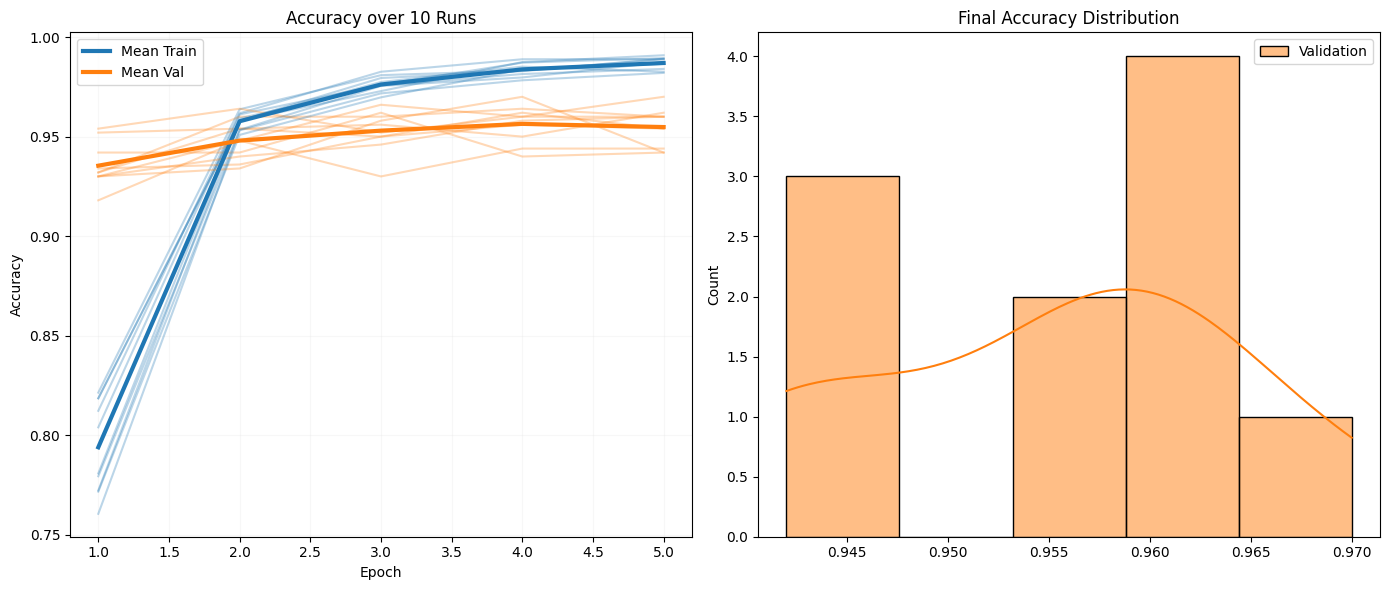

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Learning Rate: 0.001


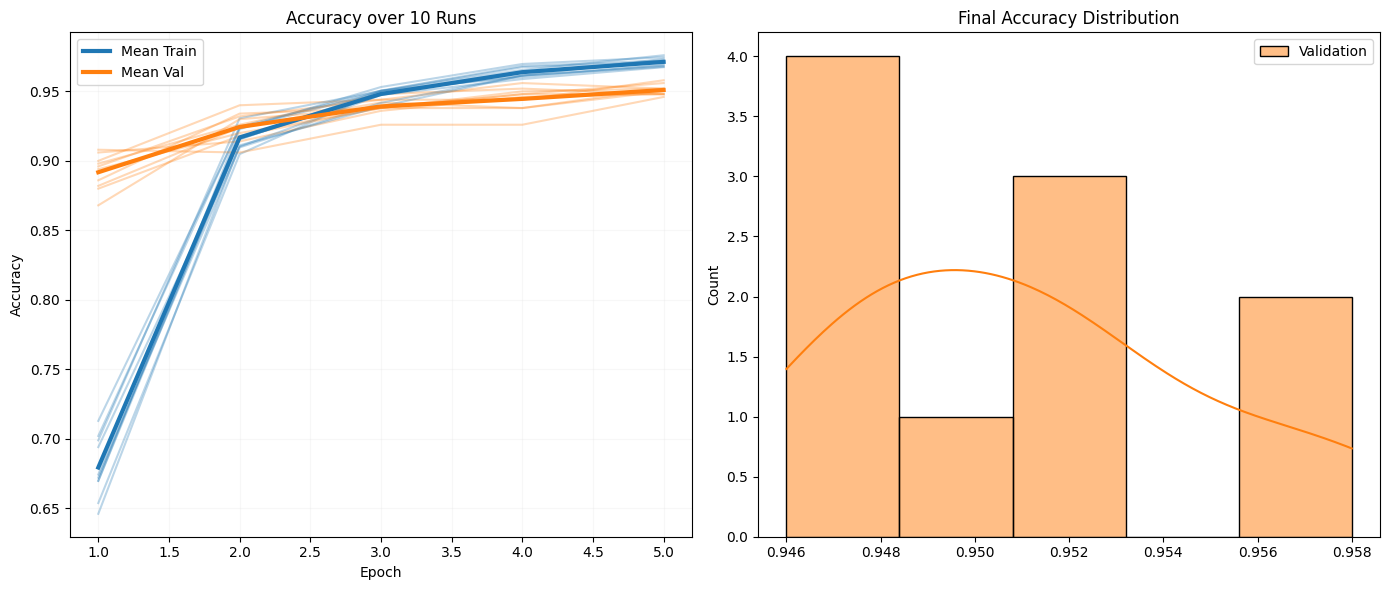


Learning Rate: 0.0001


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


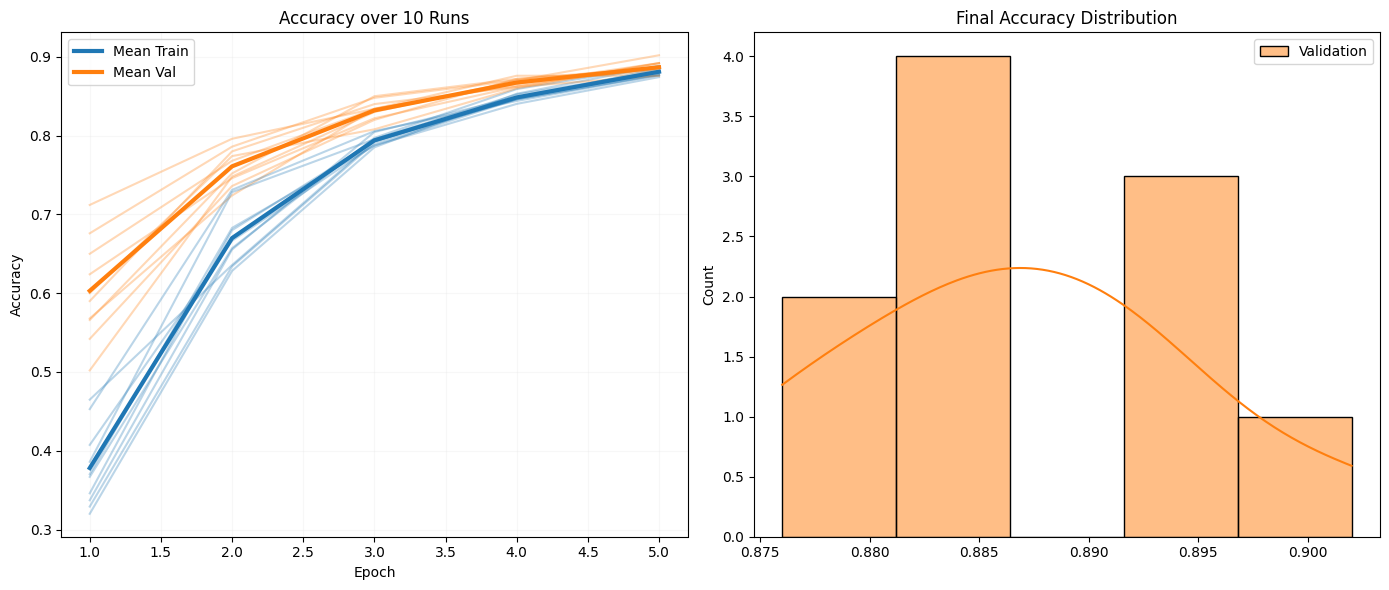

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Learning Rate: 1e-05


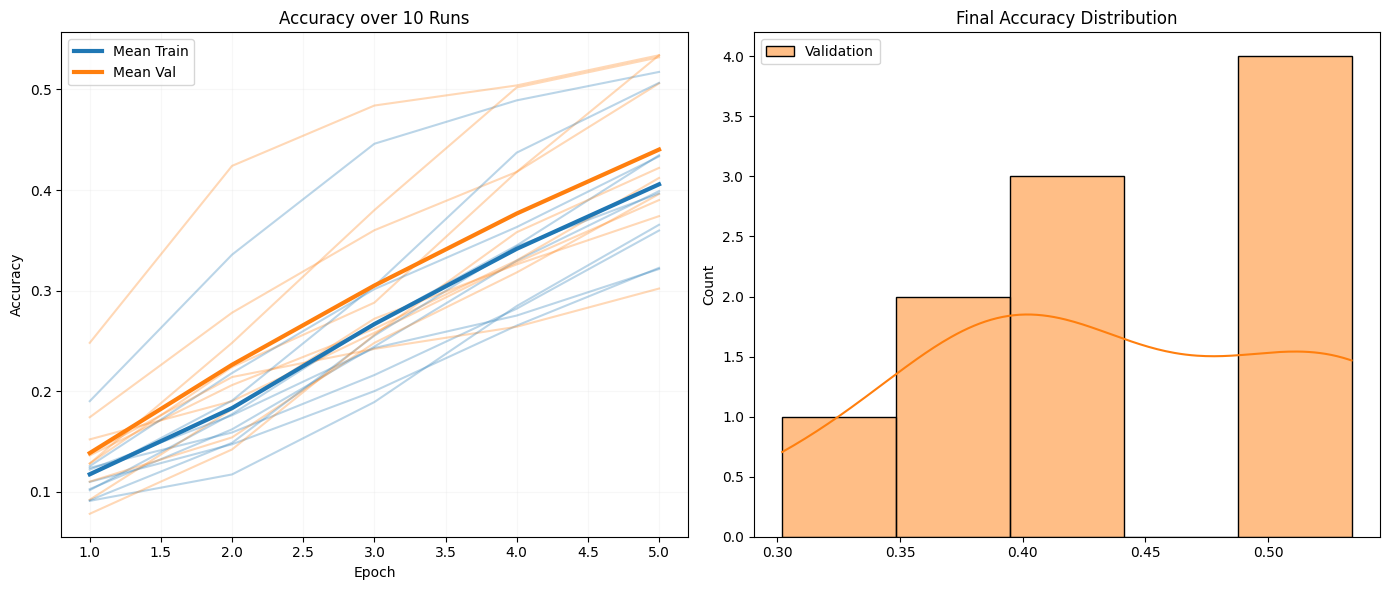

In [7]:
for lr, results in all_results.items():
    print(f"\nLearning Rate: {lr}")
    plot_variability_summary(
        all_runs_metrics_list=results.all_runs_metrics,
        final_metrics_series=results.final_val_accuracies,
        metric='accuracy'
    )

## Conclusions

For this simple image classification CNN, training the model ten times for each learning rate shows substantial variation not only in the average accuracy, but crucially in the variation.  In particular, the lowest learning rate (0.00001) shows not only very low accuracy, but a substantially higher standard deviation than the other learning rates assessed.

The clear implication is that when dealing with hyperparameter optimization, training a model _only once_ for particular hyperparameter values is insufficient, and can lead to erroneous conclusions.  In production applications, this could have dire consequences.